# Mahalanobis method

This notebook aims at evaluating the **Mahalanobis method**.

Here, we focus on a toy convolutional network trained on MNIST[0-4] and a ResNet model
trained on CIFAR-10, respectively challenged on MNIST[5-9] and SVHN OOD datasets.

**Reference**  
_A Simple Unified Framework for Detecting Out-of-Distribution Samples and Adversarial
Attacks_  
LEE, Kimin, LEE, Kibok, LEE, Honglak, et al.\
Advances in neural information processing systems, 2018, vol. 31.\
<https://arxiv.org/abs/1807.03888>


### Imports


In [ ]:
%load_ext autoreload
%autoreload 2

import os
from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
import tensorflow as tf
import matplotlib.pyplot as plt

from oodeel.methods import Mahalanobis
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import load_data_handler
from oodeel.utils.tf_training_tools import train_tf_model

clear_output()

Note that models are saved at _~/.oodeel/saved_models_ and data is supposed to be found
at _~/.oodeel/datasets_ by default. Change the following cell for a custom path.


In [2]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## First experiment: MNIST[0-4] vs MNIST[5-9]

For this first experiment, we train a toy convolutional network on the MNIST dataset
restricted to digits 0 to 4. After fitting the train subset of this dataset to the
Mahalanobis method, we will compare the scores returned for MNIST[0-4] (in-distribution)
and MNIST[5-9] (out-of-distribution) test subsets.


### Data loading

- In-distribution data: MNIST[0-4]
- Out-of-distribution data: MNIST[5-9]

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD)
> data with `_out` to avoid confusion with OOD detection which is the name of the task,
> and is therefore used to denote the core class
> `OODBaseDetector`.


In [3]:
# === Load ID and OOD data ===
batch_size = 128
in_labels = [0, 1, 2, 3, 4]

# 1- Load train/test MNIST dataset
data_handler = load_data_handler("tensorflow")

# 1- Load train/test MNIST dataset
ds_train = data_handler.load_dataset("mnist", load_kwargs=dict(split="train"))
data_test = data_handler.load_dataset("mnist", load_kwargs=dict(split="test"))

# 2- Split ID / OOD data depending on label value:
# in-distribution: MNIST[0-4] / out-of-distribution: MNIST[5-9]
ds_train, _ = data_handler.split_by_class(ds_train, in_labels)
ds_in, ds_out = data_handler.split_by_class(data_test, in_labels)


# 3- Prepare data (preprocess, shuffle, batch)
def preprocess_fn(inputs):
    inputs["image"] /= 255
    return inputs


ds_train = data_handler.prepare(
    ds_train, batch_size, preprocess_fn, shuffle=True, columns=["image", "label"]
)
ds_in = data_handler.prepare(
    ds_in, batch_size, preprocess_fn, columns=["image", "label"]
)
ds_out = data_handler.prepare(
    ds_out, batch_size, preprocess_fn, columns=["image", "label"]
)

clear_output()

### Model training

Now let's train a simple model on MNIST[0-4] using `train_tf_model` function.


41/41 [==============================] - 1s 8ms/step - loss: 0.0118 - accuracy: 0.9965
Test accuracy:	0.9965

=== Penultimate features viz ===


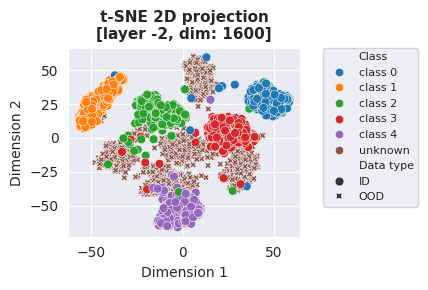

In [4]:
# === Train / Load model ===
model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4.h5")

try:
    # if the model exists, load it
    model = tf.keras.models.load_model(model_path_mnist_04)
except OSError:
    # else, train a new model
    train_config = {
        "model": "toy_convnet",
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in,
    }

    model = train_tf_model(ds_train, **train_config)

_, accuracy = model.evaluate(ds_in)
print(f"Test accuracy:\t{accuracy:.4f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### Mahalanobis score

We now fit a Mahalanobis OOD detector with MNIST[0-4] train dataset, and compare OOD
scores returned for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.


=== Metrics ===
auroc      0.892644
fpr95tpr   0.420121

=== Plots ===


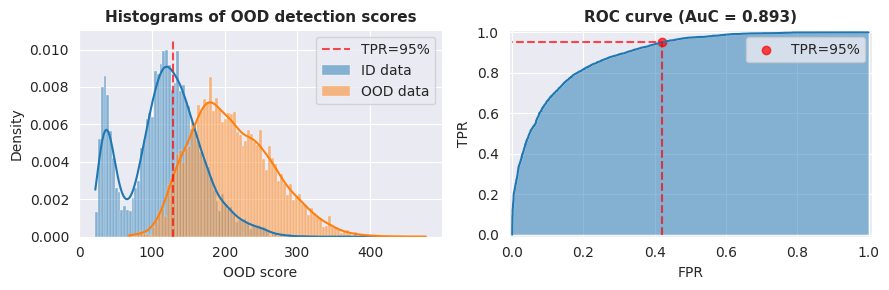

In [5]:
# === Mahalanobis scores ===
mahalanobis = Mahalanobis(eps=0.002)
mahalanobis.fit(model, feature_layers_id=[-2], fit_dataset=ds_train)
scores_in, _ = mahalanobis.score(ds_in)
scores_out, _ = mahalanobis.score(ds_out)
clear_output()

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

## Second experiment: CIFAR-10 vs SVHN

For this second experiment, we oppose **CIFAR-10** (in-distribution dataset) to **SVHN**
(out-of-distribution dataset).


### Data loading

- In-distribution data: CIFAR-10
- Out-of-distribution data: SVHN


In [6]:
# === Load ID and OOD data ===
batch_size = 128

data_handler = load_data_handler("tensorflow")

# 1a- Load in-distribution dataset: CIFAR-10
ds_fit = data_handler.load_dataset("cifar10", load_kwargs={"split": "train"})
ds_in = data_handler.load_dataset("cifar10", load_kwargs={"split": "test"})

# 1b- Load out-of-distribution dataset: SVHN
ds_out = data_handler.load_dataset("svhn_cropped", load_kwargs={"split": "test"})


# 2- prepare data (preprocess, shuffle, batch)
def preprocess_fn(inputs):
    inputs["image"] /= 255
    return inputs


ds_fit = data_handler.prepare(
    ds_fit, batch_size, preprocess_fn, shuffle=True, columns=["image", "label"]
)
ds_in = data_handler.prepare(
    ds_in, batch_size, preprocess_fn, columns=["image", "label"]
)
ds_out = data_handler.prepare(
    ds_out, batch_size, preprocess_fn, columns=["image", "label"]
)

### Model loading

The model is a **ResNet** pretrained on CIFAR-10 and getting an accuracy score of
92.75%.


79/79 [==============================] - 2s 9ms/step - loss: 0.1268 - accuracy: 0.9275
Test accuracy:	0.9275

=== Penultimate features viz ===


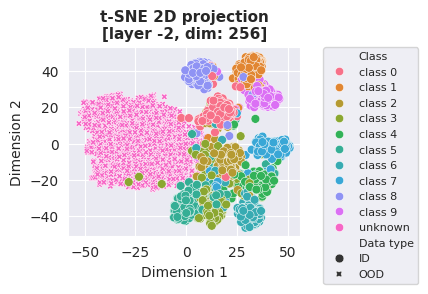

In [7]:
# === Load model ===
# ResNet pretrained on CIFAR-10
model_path_resnet_cifar10 = tf.keras.utils.get_file(
    "cifar10_resnet256.h5",
    origin="https://share.deel.ai/s/kram9kLpx6JwRX4/download/cifar10_resnet256.h5",
    cache_dir=model_path,
    cache_subdir="",
)
model = tf.keras.models.load_model(model_path_resnet_cifar10)

# Evaluate model
model.compile(metrics=["accuracy"])
_, accuracy = model.evaluate(ds_in)
print(f"Test accuracy:\t{accuracy:.4f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### Mahalanobis score

We now fit a Mahalanobis OOD detector with CIFAR-10 train dataset, and compare OOD
scores returned for CIFAR-10 (ID) and SVHN (OOD) test datasets.


=== Metrics ===
auroc      0.973386
fpr95tpr   0.133500

=== Plots ===


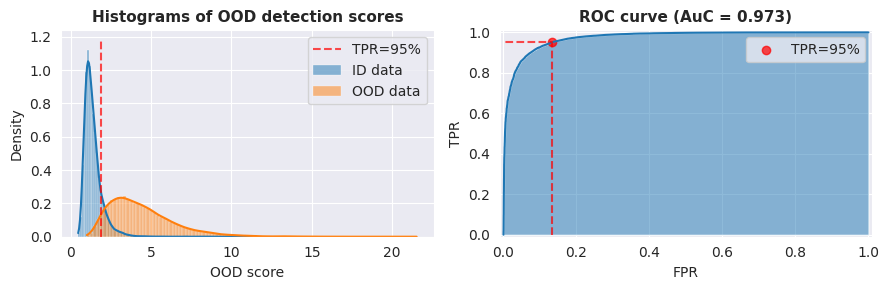

In [8]:
from oodeel.aggregator import StdNormalizedAggregator

# === Mahalanobis OOD scores ===
mahalanobis = Mahalanobis(eps=0.002, aggregator=StdNormalizedAggregator())
mahalanobis.fit(
    model,
    feature_layers_id=[
        "conv2d_18",
        "activation_17",
        "conv2d_37",
        "activation_35",
        "conv2d_56",
        "activation_53",
    ],
    fit_dataset=ds_fit,
)
scores_in, _ = mahalanobis.score(ds_in)
scores_out, _ = mahalanobis.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()